In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-166d7783-762d-5f61-b31c-549eb4e0fba0"

In [2]:
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm
import gzip

import matplotlib.pyplot as plt

from utils import *

import sys
sys.path.append("../2_train_models")
from file_configs import FoldFilesConfig, MergedFilesConfig
from data_loading import extract_observed_profiles, extract_sequences

sys.path.append("../3_eval_models")
from eval_utils import model_predict_with_rc

sys.path.append("../figure_notebooks")
from load_annotations_utils import load_coords_with_summits
from common_functions import load_coords

from puffin import *

/users/kcochran/miniconda3/envs/puffin/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# specify what set of models to look at
cell_type_A673 = "A673"

# the unique IDs for each of the folds / models in this cell type
timestamps_A673 = ["2023-06-11_20-11-32",
              "2023-06-11_23-42-00",
              "2023-06-12_03-29-06",
              "2023-06-12_07-17-43",
              "2023-06-12_11-10-59",
              "2023-06-12_14-36-40",
              "2023-06-12_17-26-09"]

retrained_procapnet_path = "retrained_procapnet_models/models/2024-08-07_04-54-46.model"

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

In [4]:
# Load the config object for when model outputs were merged across all folds

merged_config = MergedFilesConfig(cell_type, model_type, data_type)
merged_config_A673 = MergedFilesConfig(cell_type_A673, model_type, data_type)


# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = merged_config.proj_dir
genome_path = merged_config.genome_path
chrom_sizes = merged_config.chrom_sizes

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [5]:
# the puffin aggregated PRO-cap data, in log10 + 1 space
puffin_agg_plus_bw = "data/resources/agg.plus.allprocap.bedgraph.sorted.merged.bw"
puffin_agg_minus_bw = "data/resources/agg.minus.allprocap.bedgraph.sorted.merged.bw"

## First Benchmark: Puffin vs. ProCapNet on K562 PRO-cap, K562 peaks

The order of the benchmarks got flipped in the actual supplement text. So this is Figure S6B.

### Load all of the data for this peak set

In [39]:
K562_true_profs, K562_pseudorep1_profs, K562_pseudorep2_profs, \
    K562_procapnet_pred_profs, K562_procapnet_pred_logcounts = load_procapnet_test_data(merged_config,
                                                                                        timestamps)

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Loading Profiles: 4334it [00:01, 2791.99it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 3259.56it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:01, 3360.33it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:01, 3413.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


Loading Profiles: 4559it [00:01, 3603.37it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3578.44it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887


Loading Profiles: 3887it [00:01, 3450.91it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 3553.05it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:01, 3438.19it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:01, 3508.01it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 3570.36it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3513.63it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Loading Profiles: 4347it [00:01, 3740.62it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3703.69it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


### Generate Puffin Predictions

In [10]:
# Load puffin model
puffin = Puffin(use_cuda=True)

In [11]:
def puffin_predict(genome_path, chrom_sizes, puffin_model, peak_path):
    # puffin's API wants sequences as strings, not numpy arrays
    # and to make 1kb prediction, it requires 1650bp of input sequence
    seqs = extract_sequences_not_ohe(genome_path, chrom_sizes,
                                     peak_path, in_window=1650)
    preds = []
    for seq in seqs:
        raw_pred_df = puffin_model.predict(seq)
        # select for the PRO-cap + and - strands from all outputs;
        # since Puffin's outputs are in natural-log-plus-one scale,
        # also convert to raw (aggregate dataset) counts scale
        pred = np.exp(np.array([np.array(raw_pred_df)[6],
                         np.array(raw_pred_df)[-1]]).astype(float)) - 1
        preds.append(pred)
        
    return np.array(preds) 

In [12]:
K562_puffin_pred_profs = puffin_predict(genome_path, chrom_sizes,
                                        puffin, merged_config.all_peak_path)

np.save("pred_profs_puffin_K562_peaks.npy", K562_puffin_pred_profs)

# to load back in if needed
#K562_puffin_pred_profs = np.load("pred_profs_puffin_K562_peaks.npy")

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]
Loading Peaks: 30534it [00:00, 30884.63it/s]


### Generate Predictions From Other-Cell-Type ProCapNet For Comparison

In [18]:
def wrong_cell_procapnet_predict(genome_path, chrom_sizes,
                                 predict_bed_path, other_cell_type, timestamp):
    
    config = FoldFilesConfig(other_cell_type, model_type, fold = "1", timestamp = timestamp)
    
    model = torch.load(config.model_save_path)
    model.eval()
    model = model.cuda()

    # load sequences for K562 peak set
    onehot_seqs = extract_sequences(genome_path, chrom_sizes,
                                    predict_bed_path,
                                    in_window=in_window,
                                    verbose=True)

    # make predictions on K562 peaks, using not-K562 model
    pred_profiles, _ = model_predict_with_rc(model, onehot_seqs)
    return np.exp(pred_profiles)

wrongcell_pcn_pred_profs = wrong_cell_procapnet_predict(genome_path, chrom_sizes,
                                                      merged_config.all_peak_path,
                                                      cell_type_A673,
                                                      timestamps_A673[0])

Timestamp: 2023-06-11_20-11-32
Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.56it/s]
Loading Peaks: 30534it [00:27, 1114.12it/s]


== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length: 2114
Num. Examples: 30534


### Compute Performance Metrics

In [19]:
fold_labels = make_fold_labels(merged_config)
K562_avg_profs_over_folds = get_avg_train_obs_profile_over_folds(K562_true_profs, fold_labels)

In [20]:
jsds = defaultdict(lambda :  dict())
pearson_rs = defaultdict(lambda :  dict())

# compare procapnet predictions vs. observed data on the K562 peak test sets
jsds["K562_peaks_and_data"]["procapnet"], \
    pearson_rs["K562_peaks_and_data"]["procapnet"] = calc_profile_jsds_and_corrs(K562_true_profs,
                                                                                 K562_procapnet_pred_profs)

# same for puffin
jsds["K562_peaks_and_data"]["puffin"], \
    pearson_rs["K562_peaks_and_data"]["puffin"] = calc_profile_jsds_and_corrs(K562_true_profs,
                                                                              K562_puffin_pred_profs)


# baseline 1: observed data pseudoreplicate 1 vs. observed data pseudoreplicate 2 on test sets
jsds["K562_peaks_and_data"]["pseudoreps"], \
    pearson_rs["K562_peaks_and_data"]["pseudoreps"] = calc_profile_jsds_and_corrs(K562_pseudorep1_profs,
                                                                                  K562_pseudorep2_profs)

# baseline 2: average data profile in the training + validation set vs. observed data on test sets
jsds["K562_peaks_and_data"]["avg_prof"], \
    pearson_rs["K562_peaks_and_data"]["avg_prof"] = calc_profile_jsds_and_corrs(K562_true_profs,
                                                                                K562_avg_profs_over_folds)


# repeat for another procapnet trained on the wrong cell type
jsds["K562_peaks_and_data"]["pcn_A673"], \
    pearson_rs["K562_peaks_and_data"]["pcn_A673"] = calc_profile_jsds_and_corrs(K562_true_profs,
                                                                              wrongcell_pcn_pred_profs)

In [26]:
def plot_metric_cdf_with_puffin(metrics_procapnet, metrics_puffin,
                                metrics_upper=None, metrics_lower=None,
                                metrics_other=None,
                                xlabel=None, ylabel=None, other_label=None,
                                save_path = None):

    assert len(metrics_procapnet) == len(metrics_puffin)
    
    fig = plt.figure(figsize=(2,1), dpi=300)
    
    # need to sort to plot cdf correctly
    metrics_procapnet = np.sort(metrics_procapnet)
    metrics_puffin = np.sort(metrics_puffin)
    
    cdf = np.array(range(len(metrics_procapnet)))/float(len(metrics_procapnet))

    if not metrics_lower is None:
        metrics_lower = np.sort(metrics_lower)
        plt.plot(metrics_lower, cdf, color="#A0CB95", alpha=1,
                 label="Avg. Profile vs. Measured")
    
    plt.plot(metrics_puffin, cdf, color="blue", alpha=1, label="Puffin vs. Measured")
    
    if not metrics_other is None:
        metrics_other = np.sort(metrics_other)
        plt.plot(metrics_other, cdf, color="darkorange", alpha=1,
                 label=other_label)
    
    plt.plot(metrics_procapnet, cdf, color="#3C863C", alpha=1, label="ProCapNet vs. Measured")
    
    if not metrics_upper is None:
        metrics_upper = np.sort(metrics_upper)
        plt.plot(metrics_upper, cdf, color="#003123", alpha=1,
                 label="Pseudoreplicates")
    
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)
    
    legend_y_pos = 2.15
    if metrics_lower is None:
        legend_y_pos -= 0.2
    if metrics_upper is None:
        legend_y_pos -= 0.2 
    if metrics_other is None:
        legend_y_pos -= 0.2 
        
    plt.legend(fontsize=6.5, frameon=False, loc="upper center",
               bbox_to_anchor=(0.5,legend_y_pos))

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.1)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.tick_params("y", length=0, labelsize=7)
    ax.tick_params("x", length=2, labelsize=7)

    if "Jensen" in xlabel:
        plt.xlim(-0, 1.01)
    else:
        plt.xlim(-0.1, 1.02)
        
    plt.xticks([0, 0.5, 1.], fontsize=6)
    plt.yticks([0, 1], fontsize=6)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

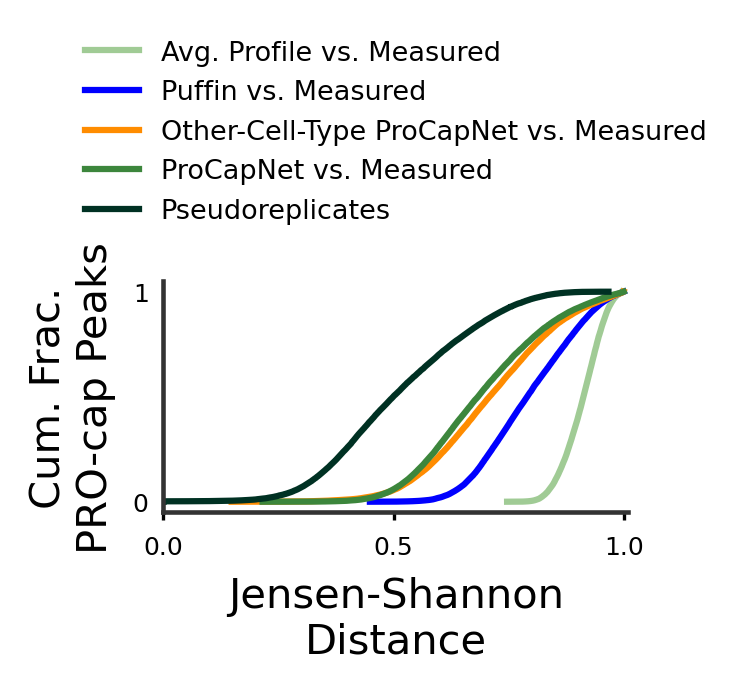

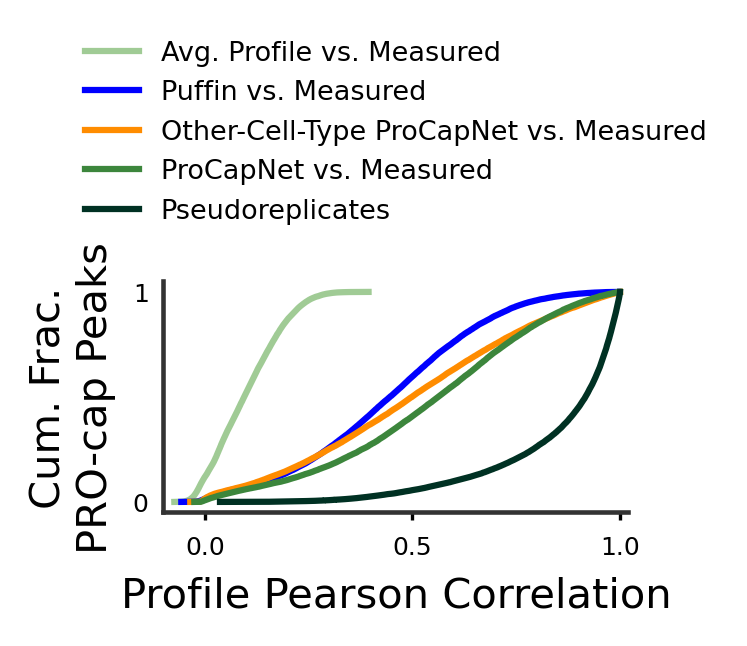

In [29]:
plot_metric_cdf_with_puffin(jsds["K562_peaks_and_data"]["procapnet"],
                            jsds["K562_peaks_and_data"]["puffin"], 
                            metrics_upper = jsds["K562_peaks_and_data"]["pseudoreps"],
                            metrics_lower = jsds["K562_peaks_and_data"]["avg_prof"],
                            metrics_other = jsds["K562_peaks_and_data"]["pcn_A673"],
                            xlabel="Jensen-Shannon\nDistance",
                            ylabel="Cum. Frac.\nPRO-cap Peaks",
                            other_label="Other-Cell-Type ProCapNet vs. Measured",
                            save_path = figures_dir + "jsds_with_puffin_final.png")

plot_metric_cdf_with_puffin(pearson_rs["K562_peaks_and_data"]["procapnet"],
                            pearson_rs["K562_peaks_and_data"]["puffin"], 
                            metrics_upper = pearson_rs["K562_peaks_and_data"]["pseudoreps"],
                            metrics_lower = pearson_rs["K562_peaks_and_data"]["avg_prof"],
                            metrics_other = pearson_rs["K562_peaks_and_data"]["pcn_A673"],
                            xlabel="Profile Pearson Correlation",
                            ylabel="Cum. Frac.\nPRO-cap Peaks",
                            other_label="Other-Cell-Type ProCapNet vs. Measured",
                            save_path = figures_dir + "pearson_r_with_puffin_final.png")

### Print Out Average Metrics

In [30]:
K562_procapnet_norm_jsds = normalize_profile_metric(jsds["K562_peaks_and_data"]["procapnet"],
                                                    jsds["K562_peaks_and_data"]["pseudoreps"],
                                                    jsds["K562_peaks_and_data"]["avg_prof"],
                                                    bigger_is_worse = True)

K562_puffin_norm_jsds = normalize_profile_metric(jsds["K562_peaks_and_data"]["puffin"],
                                                 jsds["K562_peaks_and_data"]["pseudoreps"],
                                                 jsds["K562_peaks_and_data"]["avg_prof"],
                                                 bigger_is_worse = True)

K562_pcnA673_norm_jsds = normalize_profile_metric(jsds["K562_peaks_and_data"]["pcn_A673"],
                                                 jsds["K562_peaks_and_data"]["pseudoreps"],
                                                 jsds["K562_peaks_and_data"]["avg_prof"],
                                                 bigger_is_worse = True)

K562_procapnet_norm_rs = normalize_profile_metric(pearson_rs["K562_peaks_and_data"]["procapnet"],
                                           pearson_rs["K562_peaks_and_data"]["pseudoreps"],
                                           pearson_rs["K562_peaks_and_data"]["avg_prof"])

K562_puffin_norm_rs = normalize_profile_metric(pearson_rs["K562_peaks_and_data"]["puffin"],
                                               pearson_rs["K562_peaks_and_data"]["pseudoreps"],
                                               pearson_rs["K562_peaks_and_data"]["avg_prof"])

In [33]:
print("============      ProCapNet:     ============\n")

print("--- Pearson Corr ---")
stratify_profile_metrics_over_folds(pearson_rs["K562_peaks_and_data"]["procapnet"], fold_labels)

print("--- Normalized Pearson Corr ---")
stratify_profile_metrics_over_folds(K562_procapnet_norm_rs, fold_labels)

print("--- JSD ---")
stratify_profile_metrics_over_folds(jsds["K562_peaks_and_data"]["procapnet"], fold_labels)

print("--- Normalized JSD ---")
stratify_profile_metrics_over_folds(K562_procapnet_norm_jsds, fold_labels)


print("\n\n\n============      Puffin:     ============\n")

print("--- Pearson Corr ---")
stratify_profile_metrics_over_folds(pearson_rs["K562_peaks_and_data"]["puffin"], fold_labels)

print("--- Normalized Pearson Corr ---")
stratify_profile_metrics_over_folds(K562_puffin_norm_rs, fold_labels)

print("--- JSD ---")
stratify_profile_metrics_over_folds(jsds["K562_peaks_and_data"]["puffin"], fold_labels)

print("--- Normalized JSD ---")
stratify_profile_metrics_over_folds(K562_puffin_norm_jsds, fold_labels)


print("\n\n\n============      Wrong-Cell ProCapNet:     ============\n")

print("--- JSD ---")
stratify_profile_metrics_over_folds(jsds["K562_peaks_and_data"]["pcn_A673"], fold_labels)

print("--- Normalized JSD ---")
stratify_profile_metrics_over_folds(K562_pcnA673_norm_jsds, fold_labels)

============      ProCapNet:     ============

--- Pearson Corr ---
Metric Average Within Each Fold's Test Set:
[0.5391643930372261, 0.5501057186351691, 0.5234672878400162, 0.5310877059070708, 0.5387542380879435, 0.5485743043879798, 0.5501547345992182]

Metric Average, Averaged Across Folds:
0.5401869117849463

Standard Deviation of Metric Average Across Folds:
0.009513359378455535 

--- Normalized Pearson Corr ---
Metric Average Within Each Fold's Test Set:
[0.5739815546420901, 0.5847476703567741, 0.5578779233694028, 0.5626139379172975, 0.5774083499434065, 0.5860677714574687, 0.5898065528671115]

Metric Average, Averaged Across Folds:
0.5760719657933644

Standard Deviation of Metric Average Across Folds:
0.01122573763435877 

--- JSD ---
Metric Average Within Each Fold's Test Set:
[0.6909394299011592, 0.6870753330705576, 0.6995797923847845, 0.6951706020671616, 0.6952935975883707, 0.6892008455841674, 0.6910371055125749]

Metric Average, Averaged Across Folds:
0.6926138151583966

Standa

## Benchmark 2: Re-trained ProCapNet vs. Puffin on Puffin Test Set + Aggregate Data

The order of the benchmarks got flipped in the actual supplement text. So this is Figure S6A.

In [6]:
puffin_promoter_trainset_bed = "puffin_data_train_val_test_split/train_set_from_ksenia.bed.gz"
puffin_promoter_testset_bed = "puffin_data_train_val_test_split/test_set_from_ksenia.bed.gz"

In [36]:
puffin_testset_coords = load_coords(puffin_promoter_testset_bed, in_window=1000)

In [7]:
true_profs_puffin_testset = extract_observed_profiles(puffin_agg_plus_bw,
                                                      puffin_agg_minus_bw,
                                                      puffin_promoter_testset_bed,
                                                      out_window=out_window,
                                                      verbose=True)

# based on their browswer view of the data, the bigwigs have log-10 - 1 scaled data
true_profs_puffin_testset = np.power(10, true_profs_puffin_testset) - 1

Loading Profiles: 4925it [00:02, 1720.67it/s]

== In Extract Profiles ==
Peak filepath: test_set_for_real/test_set_from_ksenia.bed.gz
Profile length: 1000
Num. Examples: 4925


In [8]:
def get_avg_prof_puffin_promoters(true_profs, n_examples=None):
    avg_prof = np.mean(true_profs, axis=0)
    if n_examples is None:
        return np.array([avg_prof for _ in range(len(true_profs))])
    return np.array([avg_prof for _ in range(n_examples)])


true_profs_puffin_trainset = extract_observed_profiles(puffin_agg_plus_bw,
                                                      puffin_agg_minus_bw,
                                                      puffin_promoter_trainset_bed,
                                                      out_window=out_window,
                                                      verbose=True)

# because the puffin bigwigs are log-10 + 1, need to exponentiate here
true_profs_puffin_trainset = np.power(10, true_profs_puffin_trainset) - 1

avg_prof_puffin_promoters_train = get_avg_prof_puffin_promoters(true_profs_puffin_trainset,
                                                       n_examples = len(true_profs_puffin_testset))

Loading Profiles: 35410it [00:24, 1437.03it/s]


== In Extract Profiles ==
Peak filepath: test_set_for_real/train_set_from_ksenia.bed.gz
Profile length: 1000
Num. Examples: 35410


In [38]:
from BPNet_strand_merged_umap import Model

def get_retrained_procapnet_pred_profs_puffin_promoters(genome_path, chrom_sizes,
                                                        puffin_promoters_path, model_path):
    model = torch.load(model_path)
    model.eval()
    model = model.cuda()

    # load data for peak set
    onehot_seqs = extract_sequences(genome_path, chrom_sizes,
                                    puffin_promoters_path,
                                    in_window=in_window,
                                    verbose=True)

    # make predictions
    pred_profiles, _ = model_predict_with_rc(model, onehot_seqs)
    return np.exp(pred_profiles)

puffintestset_retrainpcn_pred_profs = get_retrained_procapnet_pred_profs_puffin_promoters(genome_path, chrom_sizes,
                                                                                          puffin_promoter_testset_bed,
                                                                                          retrained_procapnet_path)

np.save("pred_profs_procapnet_puffin_testset.npy", puffintestset_retrainpcn_pred_profs)

# load back in later if needed
#puffintestset_retrainpcn_pred_profs = np.load("pred_profs_procapnet_puffin_testset.npy")

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.66it/s]
Loading Peaks: 4925it [00:04, 1116.43it/s]


== In Extract Sequences ==
Peak filepath: test_set_for_real/test_set_from_ksenia.bed.gz
Sequence length: 2114
Num. Examples: 4925


In [39]:
puffintestset_puffin_pred_profs = puffin_predict(genome_path, chrom_sizes, puffin,
                                                    puffin_promoter_testset_bed)
np.save("pred_profs_puffin_puffin_testset.npy", puffintestset_puffin_pred_profs)

# load back in later if needed
#puffintestset_puffin_pred_profs = np.load("pred_profs_puffin_puffin_testset.npy")

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.66it/s]
Loading Peaks: 4925it [00:00, 31008.89it/s]


In [11]:
# a couple of the promoters in the Puffin test set have no data at them,
# probably because they were selected based on only CAGE signal;
# we filter these out
where_data_testset = true_profs_puffin_testset.sum(axis=(-1,-2)) > 0

In [12]:
# only run if you didn't run the cells of the first benchmark, otherwise will overwrite
#jsds = defaultdict(lambda :  dict())
#pearson_rs = defaultdict(lambda :  dict())

In [13]:
# compare model predictions vs. observed data on the test sets
jsds["puffintestset"]["procapnet"], \
    pearson_rs["puffintestset"]["procapnet"] = calc_profile_jsds_and_corrs(true_profs_puffin_testset[where_data_testset],
                                                                 puffintestset_retrainpcn_pred_profs[where_data_testset])

# same for puffin
jsds["puffintestset"]["puffin"], \
    pearson_rs["puffintestset"]["puffin"] = calc_profile_jsds_and_corrs(true_profs_puffin_testset[where_data_testset],
                                                                        puffintestset_puffin_pred_profs[where_data_testset])

# no baseline 1 - no pseudoreps for this data

# baseline 2: average data profile in the training + validation set vs. observed data on test sets
jsds["puffintestset"]["avg_prof"], \
    pearson_rs["puffintestset"]["avg_prof"] = calc_profile_jsds_and_corrs(true_profs_puffin_testset[where_data_testset],
                                                                    avg_prof_puffin_promoters_train[where_data_testset])


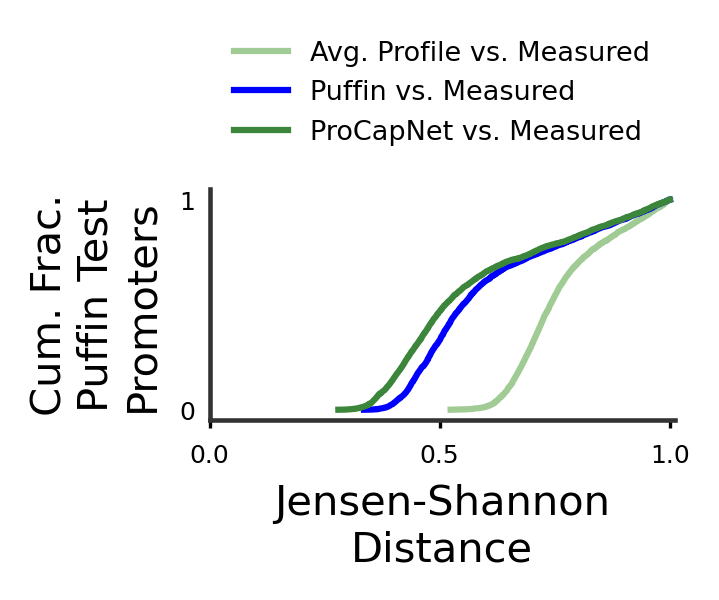

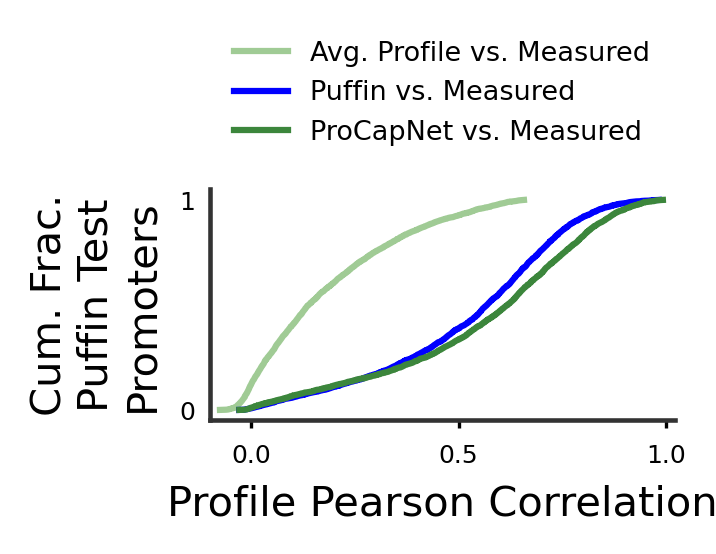

In [43]:
plot_metric_cdf_with_puffin(jsds["puffintestset"]["procapnet"],
                            jsds["puffintestset"]["puffin"],
                            metrics_lower = jsds["puffintestset"]["avg_prof"],
                            xlabel="Jensen-Shannon\nDistance",
                            ylabel="Cum. Frac.\nPuffin Test\nPromoters",
                            save_path = figures_dir + "jsds_with_puffin_puffin_testset.png")

plot_metric_cdf_with_puffin(pearson_rs["puffintestset"]["procapnet"],
                            pearson_rs["puffintestset"]["puffin"],
                            metrics_lower = pearson_rs["puffintestset"]["avg_prof"],
                            xlabel="Profile Pearson Correlation",
                            ylabel="Cum. Frac.\nPuffin Test\nPromoters",
                            save_path = figures_dir + "pearson_r_with_puffin_puffin_testset.png")

In [44]:
print("============      ProCapNet:     ============\n")

print("--- Pearson Corr ---")
print(np.mean(pearson_rs["puffintestset"]["procapnet"]))

print("--- JSD ---")
print(np.mean(jsds["puffintestset"]["procapnet"]))


print("\n\n\n============      Puffin:     ============\n")

print("--- Pearson Corr ---")
print(np.mean(pearson_rs["puffintestset"]["puffin"]))

print("--- JSD ---")
print(np.mean(jsds["puffintestset"]["puffin"]))

============      ProCapNet:     ============

--- Pearson Corr ---
0.5656817545039455
--- JSD ---
0.5750412797146315



============      Puffin:     ============

--- Pearson Corr ---
0.5276896513344708
--- JSD ---
0.606580507800021
